<a href="https://colab.research.google.com/github/Nagesh-Cheripally/Sentiment-analysis-on-1.6M-tweets/blob/main/1_6M_Tweets_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
!pip install pycld2

     |████████████████████████████████| 41.4MB 71kB/s 
  Created wheel for pycld2: filename=pycld2-0.41-cp36-cp36m-linux_x86_64.whl size=9833460 sha256=c8dbd6bc6a859aa6b3d2afcb96ff5a5d83ea03052fd5c45a6c0082296ce78f45
  Stored in directory: /root/.cache/pip/wheels/c6/8f/e9/08a1a8932a490175bd140206cd86a3dbcfc70498100de11079
Successfully built pycld2


In [9]:
import numpy as np
import pandas as pd

#NLP Library
import spacy
import re

#Language Detect Library
import pycld2 as cld2

#Feature extraction, model selection and model training library
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split

#Libraries to check the model performance
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

#Graphing Libraries
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as snb
from wordcloud import WordCloud, STOPWORDS

#Hypothesis Testing
import math
from scipy.stats import chi2_contingency, chisquare, chi2

In [10]:
from google.colab import files
upload = files.upload()

Saving kaggle.json to kaggle.json


In [11]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle

!chmod 600 ~/.kaggle/kaggle.json

In [12]:
!kaggle datasets download -d kazanova/sentiment140

 90% 73.0M/80.9M [00:02<00:00, 30.1MB/s]
100% 80.9M/80.9M [00:02<00:00, 32.3MB/s]


In [13]:
from zipfile import ZipFile
file_name = "sentiment140.zip"

with ZipFile(file_name, 'r') as zip:
  zip.extractall()
  print('done')

done


In [14]:
import pandas as pd
# Importing the dataset
DATASET_COLUMNS  = ["sentiment", "ids", "date", "flag", "user", "text"]
DATASET_ENCODING = "ISO-8859-1"
dataset = pd.read_csv('/content/training.1600000.processed.noemoticon.csv', encoding=DATASET_ENCODING , names=DATASET_COLUMNS)
dataset.head(5)

,sentiment,ids,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [15]:
# Removing the unnecessary columns.
dataset = dataset[['sentiment','text']]

# Replacing the values.
dataset['sentiment'] = dataset['sentiment'].replace(4,1)

In [16]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()
sns.set_style('darkgrid')

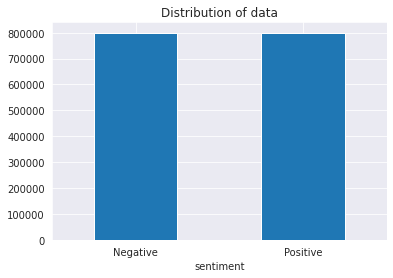

In [17]:
ax = dataset.groupby('sentiment').count().plot(kind='bar', title='Distribution of data',legend=False)
ax = ax.set_xticklabels(['Negative','Positive'], rotation=0)

In [18]:
from google.colab import files
upload = files.upload()

Saving contraction.csv to contraction.csv


In [20]:
import io
df = pd.read_csv(io.BytesIO(upload['contraction.csv']), encoding = 'unicode_escape')

In [21]:
df.head(5)

,Contraction,Meaning
0,aight,alright
1,ain't,is not
2,amn't,am not
3,aren't,are not
4,can't,cannot


In [22]:
# Reading contractions.csv and storing it as a dict.
contractions = pd.read_csv(io.BytesIO(upload['contraction.csv']), encoding = 'unicode_escape', index_col='Contraction')
contractions.index = contractions.index.str.lower()
contractions.Meaning = contractions.Meaning.str.lower()
contractions_dict = contractions.to_dict()['Meaning']

In [23]:
# Defining regex patterns.
urlPattern        = r"((http://)[^ ]*|(https://)[^ ]*|(www\.)[^ ]*)"
userPattern       = '@[^\s]+'
hashtagPattern    = '#[^\s]+'
alphaPattern      = "[^a-z0-9<>]"
sequencePattern   = r"(.)\1\1+"
seqReplacePattern = r"\1\1"

# Defining regex for emojis
smileemoji        = r"[8:=;]['`\-]?[)d]+"
sademoji          = r"[8:=;]['`\-]?\(+"
neutralemoji      = r"[8:=;]['`\-]?[\/|l*]"
lolemoji          = r"[8:=;]['`\-]?p+"

In [24]:
import re
def preprocess_apply(tweet):

    tweet = tweet.lower()

    # Replace all URls with '<url>'
    tweet = re.sub(urlPattern,'<url>',tweet)
    # Replace @USERNAME to '<user>'.
    tweet = re.sub(userPattern,'<user>', tweet)
    
    # Replace 3 or more consecutive letters by 2 letter.
    tweet = re.sub(sequencePattern, seqReplacePattern, tweet)

    # Replace all emojis.
    tweet = re.sub(r'<3', '<heart>', tweet)
    tweet = re.sub(smileemoji, '<smile>', tweet)
    tweet = re.sub(sademoji, '<sadface>', tweet)
    tweet = re.sub(neutralemoji, '<neutralface>', tweet)
    tweet = re.sub(lolemoji, '<lolface>', tweet)

    for contraction, replacement in contractions_dict.items():
        tweet = tweet.replace(contraction, str(replacement))

    # Remove non-alphanumeric and symbols
    tweet = re.sub(alphaPattern, ' ', tweet)

    # Adding space on either side of '/' to seperate words (After replacing URLS).
    tweet = re.sub(r'/', ' / ', tweet)
    return tweet

In [25]:
%%time
dataset['processed_text'] = dataset.text.apply(preprocess_apply)

CPU times: user 1min 34s, sys: 127 ms, total: 1min 34s
Wall time: 1min 34s


In [26]:
count=0
for row in dataset.itertuples():
    print("Text:", row[2])
    print("Processed:", row[3])
    count+=1
    if count>10:
        break

Text: @switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer.  You shoulda got David Carr of Third Day to do it. ;D
Processed: <uiser> <url>   aww  that is a bummer   you ishoulda got david carr of third day to do it  <ismile>
Text: is upset that he can't update his Facebook by texting it... and might cry as a result  School today also. Blah!
Processed: iis upiset that he cannot update hiis facebook by texting it   and might cry ais a reisult  ischool today aliso  blah 
Text: @Kenichan I dived many times for the ball. Managed to save 50%  The rest go out of bounds
Processed: <uiser> i dived many timeis for the ball  managed to isave 50   the reist go out of boundis
Text: my whole body feels itchy and like its on fire 
Processed: my whole body feelis itchy and like iit is on fire 
Text: @nationwideclass no, it's not behaving at all. i'm mad. why am i here? because I can't see you all over there. 
Processed: <uiser> no  it iis not behaving at all  i am mad  why am i here  bebecauis

In [27]:
dataset.head(5)

,sentiment,text,processed_text
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",<uiser> <url> aww that is a bummer you is...
1,0,is upset that he can't update his Facebook by ...,iis upiset that he cannot update hiis facebook...
2,0,@Kenichan I dived many times for the ball. Man...,<uiser> i dived many timeis for the ball mana...
3,0,my whole body feels itchy and like its on fire,my whole body feelis itchy and like iit is on ...
4,0,"@nationwideclass no, it's not behaving at all....",<uiser> no it iis not behaving at all i am m...


In [28]:
!pip install pycld2

In [29]:
#Language Detect Library
import pycld2 as cld2

In [30]:
def detect_lang(processed_text):
    try:
        isReliable, textBytesFound, details = cld2.detect(processed_text)
        return details[0][0]
    except:
        return "not found"

In [31]:
language_detection = dataset["processed_text"].apply(detect_lang)

In [32]:
language_detection.value_counts().head(15)

ENGLISH       1494010
Unknown         91131
SCOTS            5150
LATIN            1711
INDONESIAN        933
DANISH            901
PORTUGUESE        802
TAGALOG           645
ALBANIAN          351
SPANISH           302
GERMAN            291
GALICIAN          236
ROMANIAN          214
MANX              199
XHOSA             193
Name: processed_text, dtype: int64

In [33]:
processedtext = list(dataset['processed_text'])
data_pos = processedtext[800000:]
data_neg = processedtext[:800000]

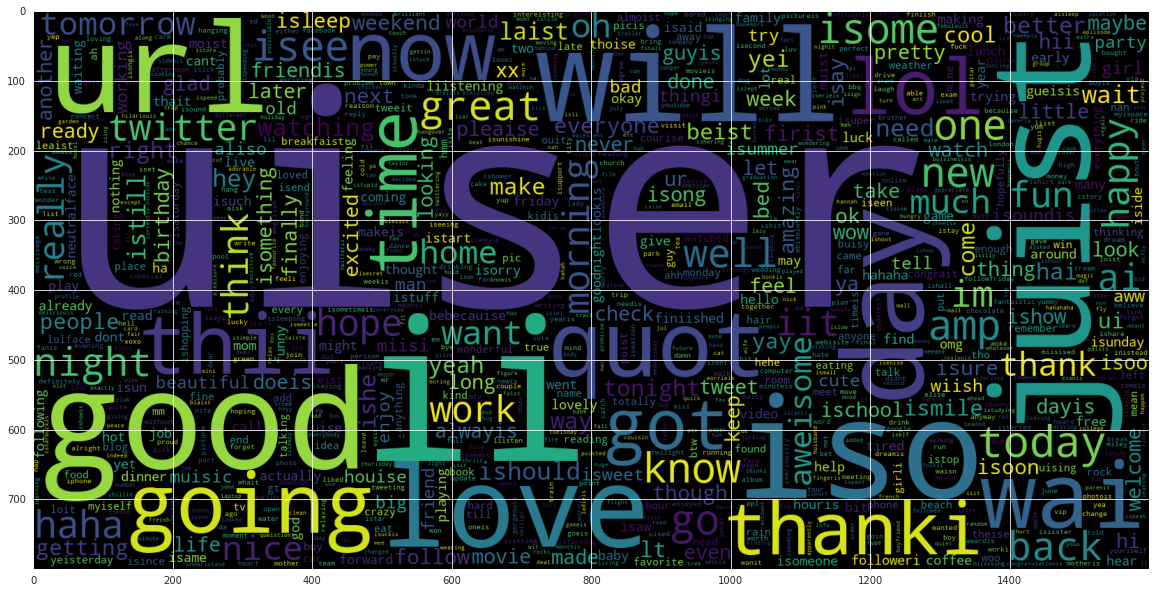

In [34]:
wc = WordCloud(max_words = 1000 , width = 1600 , height = 800, collocations=False).generate(" ".join(data_pos))
plt.figure(figsize = (20,20))
plt.imshow(wc)

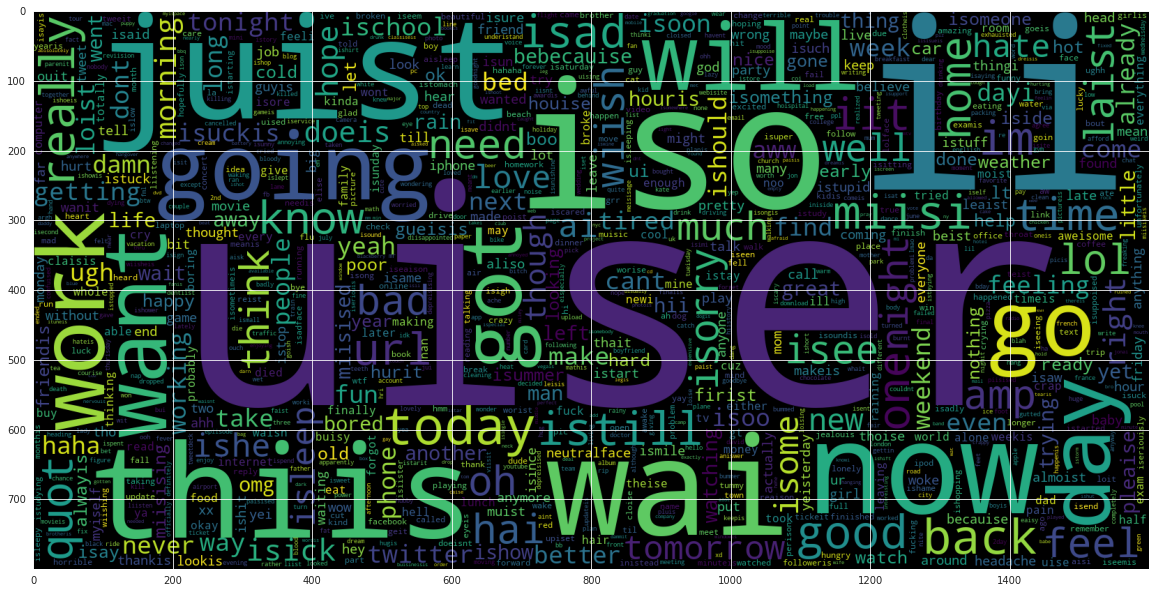

In [35]:
wc = WordCloud(max_words = 1000 , width = 1600 , height = 800, collocations=False).generate(" ".join(data_neg))
plt.figure(figsize = (20,20))
plt.imshow(wc)

In [36]:
from sklearn.model_selection import train_test_split

X_data, y_data = np.array(dataset['processed_text']), np.array(dataset['sentiment'])

X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size = 0.05, random_state = 0)
print('Data Split done.')

Data Split done.


In [37]:
from gensim.models import Word2Vec

Embedding_dimensions = 100

# Creating Word2Vec training dataset.
Word2vec_train_data = list(map(lambda x: x.split(), X_train))

In [38]:
%time

# Defining the model and training it.
word2vec_model = Word2Vec(Word2vec_train_data,
                 size=Embedding_dimensions,
                 workers=8,
                 min_count=5)

print("Vocabulary Length:", len(word2vec_model.wv.vocab))

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 5.96 µs
Vocabulary Length: 50811


In [39]:
# Defining the model input length.
input_length = 60

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [40]:
tokenizer = Tokenizer(filters="", lower=False, oov_token="<oov>")
tokenizer.fit_on_texts(X_data)

vocab_length = len(tokenizer.word_index) + 1
print("Tokenizer vocab length:", vocab_length)

Tokenizer vocab length: 262094


In [41]:
X_train = pad_sequences(tokenizer.texts_to_sequences(X_train), maxlen=input_length)
X_test  = pad_sequences(tokenizer.texts_to_sequences(X_test) , maxlen=input_length)

print("X_train.shape:", X_train.shape)
print("X_test.shape :", X_test.shape)

X_train.shape: (1520000, 60)
X_test.shape : (80000, 60)


In [42]:
embedding_matrix = np.zeros((vocab_length, Embedding_dimensions))

for word, token in tokenizer.word_index.items():
    if word2vec_model.wv.__contains__(word):
        embedding_matrix[token] = word2vec_model.wv.__getitem__(word)

print("Embedding Matrix Shape:", embedding_matrix.shape)

Embedding Matrix Shape: (262094, 100)


In [43]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Bidirectional, GlobalMaxPool1D, Dense, LSTM, Conv1D, Embedding

In [44]:
def getModel():
    embedding_layer = Embedding(input_dim = vocab_length, 
                                output_dim = Embedding_dimensions,
                                weights=[embedding_matrix], 
                                input_length=input_length,
                                trainable=False)

    model = Sequential([
        embedding_layer,
        Bidirectional(LSTM(100, dropout=0.3, return_sequences=True)),
        Bidirectional(LSTM(100, dropout=0.3, return_sequences=True)),
        Conv1D(100, 5, activation='relu'),
        GlobalMaxPool1D(),
        Dense(16, activation='relu'),
        Dense(1, activation='sigmoid'),
    ],
    name="Sentiment_Model")
    return model

In [45]:
training_model = getModel()
training_model.summary()

Model: "Sentiment_Model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 60, 100)           26209400  
_________________________________________________________________
bidirectional (Bidirectional (None, 60, 200)           160800    
_________________________________________________________________
bidirectional_1 (Bidirection (None, 60, 200)           240800    
_________________________________________________________________
conv1d (Conv1D)              (None, 56, 100)           100100    
_________________________________________________________________
global_max_pooling1d (Global (None, 100)               0         
_________________________________________________________________
dense (Dense)                (None, 16)                1616      
_________________________________________________________________
dense_1 (Dense)              (None, 1)             

In [46]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
callbacks = [ReduceLROnPlateau(monitor='val_loss', patience=5, cooldown=0),EarlyStopping(monitor='val_accuracy', min_delta=1e-4, patience=5)]

In [47]:
training_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [48]:
history = training_model.fit(
    X_train, y_train,
    batch_size=1024,
    epochs=12,
    validation_split=0.1,
    callbacks=callbacks,
    verbose=1,
)

Epoch 1/12
1336/1336 [==============================] - 132s 90ms/step - loss: 0.4619 - accuracy: 0.7786 - val_loss: 0.3948 - val_accuracy: 0.8246
Epoch 2/12
1336/1336 [==============================] - 118s 88ms/step - loss: 0.3987 - accuracy: 0.8172 - val_loss: 0.3784 - val_accuracy: 0.8295
Epoch 3/12
1336/1336 [==============================] - 118s 88ms/step - loss: 0.3859 - accuracy: 0.8244 - val_loss: 0.3756 - val_accuracy: 0.8315
Epoch 4/12
1336/1336 [==============================] - 118s 89ms/step - loss: 0.3775 - accuracy: 0.8293 - val_loss: 0.3654 - val_accuracy: 0.8367
Epoch 5/12
1336/1336 [==============================] - 118s 88ms/step - loss: 0.3713 - accuracy: 0.8326 - val_loss: 0.3634 - val_accuracy: 0.8373
Epoch 6/12
1336/1336 [==============================] - 118s 88ms/step - loss: 0.3680 - accuracy: 0.8345 - val_loss: 0.3599 - val_accuracy: 0.8411
Epoch 7/12
1336/1336 [==============================] - 118s 88ms/step - loss: 0.3644 - accuracy: 0.8362 - val_loss: 0

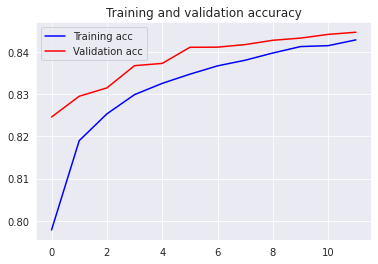

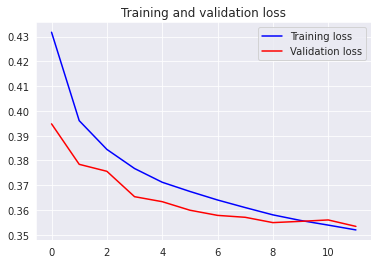

In [49]:
acc,  val_acc  = history.history['accuracy'], history.history['val_accuracy']
loss, val_loss = history.history['loss'], history.history['val_loss']
epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [53]:
from sklearn.metrics import confusion_matrix, classification_report
import __main__

def ConfusionMatrix(y_pred, y_test):
    # Compute and plot the Confusion matrix
    cf_matrix = confusion_matrix(y_test, y_pred)

    categories  = ['Negative','Positive']
    group_names = ['True Neg','False Pos', 'False Neg','True Pos']
    group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]

    labels = [f'{v1}\n{v2}' for v1, v2 in zip(group_names,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)

    sns.heatmap(cf_matrix, annot = labels, cmap = 'Blues',fmt = '',
                xticklabels = categories, yticklabels = categories)

    plt.xlabel("Predicted values", fontdict = {'size':14}, labelpad = 10)
    plt.ylabel("Actual values"   , fontdict = {'size':14}, labelpad = 10)
    plt.title ("Confusion Matrix", fontdict = {'size':18}, pad = 20)

In [54]:
# Predicting on the Test dataset.
y_pred = training_model.predict(X_test)

# Converting prediction to reflect the sentiment predicted.
y_pred = np.where(y_pred>=0.5, 1, 0)

In [55]:
# Printing out the Evaluation metrics. 
ConfusionMatrix(y_pred, y_test)

TypeError: ignored

In [57]:
# Print the evaluation metrics for the dataset.
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.84      0.85      0.84     39989
           1       0.85      0.84      0.84     40011

    accuracy                           0.84     80000
   macro avg       0.84      0.84      0.84     80000
weighted avg       0.84      0.84      0.84     80000



In [59]:
import re

hashtags = re.compile(r"^#\S+|\s#\S+")
mentions = re.compile(r"^@\S+|\s@\S+")
urls = re.compile(r"https?://\S+")

def process_text(text):
  text = hashtags.sub(' hashtag', text)
  text = mentions.sub(' entity', text)
  return text.strip().lower()
  
def match_expr(pattern, string):
  return not pattern.search(string) == None

def get_data_wo_urls(dataset):
    link_with_urls = dataset.text.apply(lambda x: match_expr(urls, x))
    return dataset[[not e for e in link_with_urls]] 

In [60]:
label_text.text = label_text.text.apply(process_text)

/usr/local/lib/python3.6/dist-packages/pandas/core/generic.py:5170: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [61]:
from sklearn.model_selection import train_test_split
TRAIN_SIZE = 0.75
VAL_SIZE = 0.05
dataset_count = len(label_text)

df_train_val, df_test = train_test_split(label_text, test_size=1-TRAIN_SIZE-VAL_SIZE, random_state=42)
df_train, df_val = train_test_split(df_train_val, test_size=VAL_SIZE / (VAL_SIZE + TRAIN_SIZE), random_state=42)

print("TRAIN size:", len(df_train))
print("VAL size:", len(df_val))
print("TEST size:", len(df_test))

TRAIN size: 1200000
VAL size: 80000
TEST size: 320000


In [62]:
df_train = get_data_wo_urls(df_train)
df_train.head()

,label,text
441493,0,entity i can't watch it until next week cos i ...
937763,1,just woke up
1106597,1,"in the garden with soph, fi, craig, and sarah ..."
1321504,1,entity can't wait to see your new hairstyle!!!
71659,0,"entity i miss you, mr. superhero. come back to..."


In [63]:
!mkdir dataset
df_train.sample(frac=1.0).reset_index(drop=True).to_csv('dataset/train.tsv', sep='\t', index=None, header=None)
df_val.to_csv('dataset/dev.tsv', sep='\t', index=None, header=None)
df_test.to_csv('dataset/test.tsv', sep='\t', index=None, header=None)
! cd dataset && ls

dev.tsv  test.tsv  train.tsv


In [65]:
!pip install BertLibrary

     |████████████████████████████████| 61kB 7.2MB/s 
  Created wheel for BertLibrary: filename=BertLibrary-0.0.4-cp36-none-any.whl size=75016 sha256=df1ba6becd3e9b49982e05547d11750839d18cac3f1b4e82b9e9460dc97a3321
  Stored in directory: /root/.cache/pip/wheels/63/3d/ab/990438ec53e97a0203d2be35ad77fcdcb0750bee7057ddf25f
Successfully built BertLibrary


In [70]:
%%time
import pandas as pd

CPU times: user 4 µs, sys: 1e+03 ns, total: 5 µs
Wall time: 7.39 µs


In [9]:
!pip install transformers

In [10]:
import numpy as np
import pandas as pd

DATASET_COLUMNS  = ["label", "ids", "date", "flag", "user", "tweet"]
DATASET_ENCODING = "ISO-8859-1"
tweet_train=pd.read_csv('/content/training.1600000.processed.noemoticon.csv', encoding=DATASET_ENCODING,names = DATASET_COLUMNS )



In [11]:

tweets = tweet_train.tweet.values
labels = tweet_train.label.values

In [12]:
from transformers import BertTokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)
tweetid = []
for tweet in tweets:
  encoded_tweet = tokenizer.encode(tweet,add_special_tokens = True,)
  tweetid.append(encoded_tweet)

print('Original: ', tweets[0])
print('Token IDs:', tweetid[0])

Original:  @switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer.  You shoulda got David Carr of Third Day to do it. ;D
Token IDs: [101, 1030, 6942, 13064, 8299, 1024, 1013, 1013, 1056, 9148, 25856, 2594, 1012, 4012, 1013, 1016, 2100, 2487, 2480, 2140, 1011, 22091, 2860, 2860, 1010, 2008, 1005, 1055, 1037, 26352, 5017, 1012, 2017, 2323, 2050, 2288, 2585, 12385, 1997, 2353, 2154, 2000, 2079, 2009, 1012, 1025, 1040, 102]


In [13]:
from keras.preprocessing.sequence import pad_sequences

MAX_LEN = 64

print('\n Truncating all sentences to %d values...' % MAX_LEN)

print('\nPadding token: "{:}", ID: {:}'.format(tokenizer.pad_token, tokenizer.pad_token_id))

tweetid = pad_sequences(tweetid, maxlen=MAX_LEN, dtype="long",value=0, truncating="post", padding="post")


 Truncating all sentences to 64 values...

Padding token: "[PAD]", ID: 0


In [14]:
masks = []
for tweet in tweetid:
  mask = [int(token_id > 0) for token_id in tweet]
  masks.append(mask)

In [15]:
from sklearn.model_selection import train_test_split

train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(tweetid, labels, random_state=2018, test_size=0.1)

train_masks, validation_masks, _, _ = train_test_split(masks, labels, random_state=2018, test_size=0.1)

In [16]:
import torch

In [17]:
train_inputs = torch.tensor(train_inputs)
validation_inputs = torch.tensor(validation_inputs)

train_labels = torch.tensor(train_labels)
validation_labels = torch.tensor(validation_labels)

train_masks = torch.tensor(train_masks)
validation_masks = torch.tensor(validation_masks)

from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

batch_size = 32

train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)
validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)

In [25]:
from transformers import BertForSequenceClassification, AdamW, BertConfig

model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased",
    num_labels = 2, 
    output_attentions = False, 
    output_hidden_states = False, 
)

model.cuda()
optimizer = AdamW(model.parameters(),
                  lr = 2e-5, 
                  eps = 1e-8 
                )

from transformers import get_linear_schedule_with_warmup

epochs = 4

total_steps = len(train_dataloader) * epochs
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, 
                                            num_training_steps = total_steps)


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

RuntimeError: ignored

In [24]:
def accuracy(preds, labels):
    pred = np.argmax(preds, axis=1).flatten()
    labels = labels.flatten()
    return np.sum(pred == labels) / len(labels)

import random
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)
device = torch.device("cuda")
loss_values = []
for epoch_i in range(0, epochs):
  print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
  total_loss = 0
  model.train()
  for step, batch in enumerate(train_dataloader):
    if step % 50 == 0 and not step == 0:
      print('  Batch {:>5,}  of  {:>5,}. '.format(step, len(train_dataloader)))
    b_input_ids = batch[0].to(device)
    b_input_mask = batch[1].to(device)
    b_labels = batch[2].to(device)

    model.zero_grad()        

    outputs = model(b_input_ids, 
                token_type_ids=None, 
                attention_mask=b_input_mask, 
                labels=b_labels)

    loss = outputs[0]    
    total_loss += loss.item()
    loss.backward()
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
    optimizer.step()
    scheduler.step()
    avg_train_loss = total_loss / len(train_dataloader)            
    loss_values.append(avg_train_loss)

    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("validation")

    model.eval()

    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0

for batch in validation_dataloader:
    batch = tuple(t.to(device) for t in batch)
    b_input_ids, b_input_mask, b_labels = batch
    with torch.no_grad():        
        outputs = model(b_input_ids, 
                        token_type_ids=None, 
                        attention_mask=b_input_mask)
    logits = outputs[0]
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()
    tmp_eval_accuracy = accuracy(logits, label_ids)
    eval_accuracy += tmp_eval_accuracy
    nb_eval_steps += 1

print("  Accuracy: {0:.2f}".format(eval_accuracy/nb_eval_steps))

======== Epoch 1 / 4 ========


RuntimeError: ignored

In [ ]:
#Graph: 

import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style='darkgrid')
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)
plt.plot(loss_values, 'b-o')
plt.title("Training loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()